In [8]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd

In [9]:
tckrs = ["ADBE", "AMAT", "AMZN", "BRK-B", "DAL", "GOOG", "MCD"]

In [18]:
start = "2021-01-19"
end = "2021-11-01"
lookahead = 5

In [19]:
dates = pd.date_range(start, end)

In [20]:
base = "/home/greg_b/voltron/experiments/trading/saved-outputs/"

In [21]:
full_predictions = []
has_dates = []
for date in dates:
    cap = str(date)[:10]
    try:
        predictions = torch.stack([torch.load(base + tckr + "/volt_ewma400_"+cap+".pt") for tckr in tckrs])
        full_predictions.append(predictions)
        has_dates.append(cap)
    except:
        print(cap)

2021-01-19
2021-01-20
2021-01-21
2021-01-22
2021-01-23
2021-01-24
2021-01-25
2021-01-26
2021-01-27
2021-01-28
2021-01-29
2021-01-30
2021-01-31
2021-02-01
2021-02-02
2021-02-03
2021-02-04
2021-02-05
2021-02-06
2021-02-07
2021-02-08
2021-02-09
2021-02-10
2021-02-11
2021-02-12
2021-02-13
2021-02-14
2021-02-15
2021-02-16
2021-02-17
2021-02-18
2021-02-19
2021-02-20
2021-02-21
2021-02-22
2021-02-23
2021-02-24
2021-02-25
2021-02-26
2021-02-27
2021-02-28
2021-03-01
2021-03-02
2021-03-03
2021-03-04
2021-03-05
2021-03-06
2021-03-07
2021-03-08
2021-03-09
2021-03-10
2021-03-11
2021-03-12
2021-03-13
2021-03-14
2021-03-15
2021-03-16
2021-03-17
2021-03-18
2021-03-19
2021-03-20
2021-03-21
2021-03-22
2021-03-23
2021-03-24
2021-03-25
2021-03-26
2021-03-27
2021-03-28
2021-03-29
2021-03-30
2021-03-31
2021-04-01
2021-04-02
2021-04-03
2021-04-04
2021-04-05
2021-04-06
2021-04-07
2021-04-08
2021-04-09
2021-04-10
2021-04-11
2021-04-12
2021-04-13
2021-04-14
2021-04-15
2021-04-16
2021-04-17
2021-04-18
2021-04-19

In [23]:
[torch.load(base + tckr + "/volt_ewma400_"+cap+".pt") for tckr in tckrs]

FileNotFoundError: [Errno 2] No such file or directory: '/home/greg_b/voltron/experiments/trading/saved-outputs/BRK-B/volt_ewma400_2021-11-01.pt'

In [7]:
daily_predictions = torch.stack(full_predictions)

RuntimeError: stack expects a non-empty TensorList

In [ ]:
daily_predictions.shape

In [9]:
from pandas.tseries.holiday import USFederalHolidayCalendar


In [10]:
date

Timestamp('2021-11-01 00:00:00', freq='D')

In [11]:
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [12]:
end_plus_20 = str(pd.date_range(start=end, periods=21, freq=bday_us)[-1])[:10]

In [13]:
observations = torch.tensor(
    [yf.download(tckr, start=start, end=end_plus_20).Close.values for tckr in tckrs]
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_21305/2183553156.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  observations = torch.tensor(


In [14]:
daily_predictions.shape

torch.Size([200, 7, 1000, 20])

In [15]:
num_obs = daily_predictions.shape[0]

In [16]:
tenday_lookahead = daily_predictions[..., lookahead].permute(1, 2, 0)

In [17]:
exp_means = tenday_lookahead.exp().mean(1)
exp_stds = tenday_lookahead.exp().std(1)

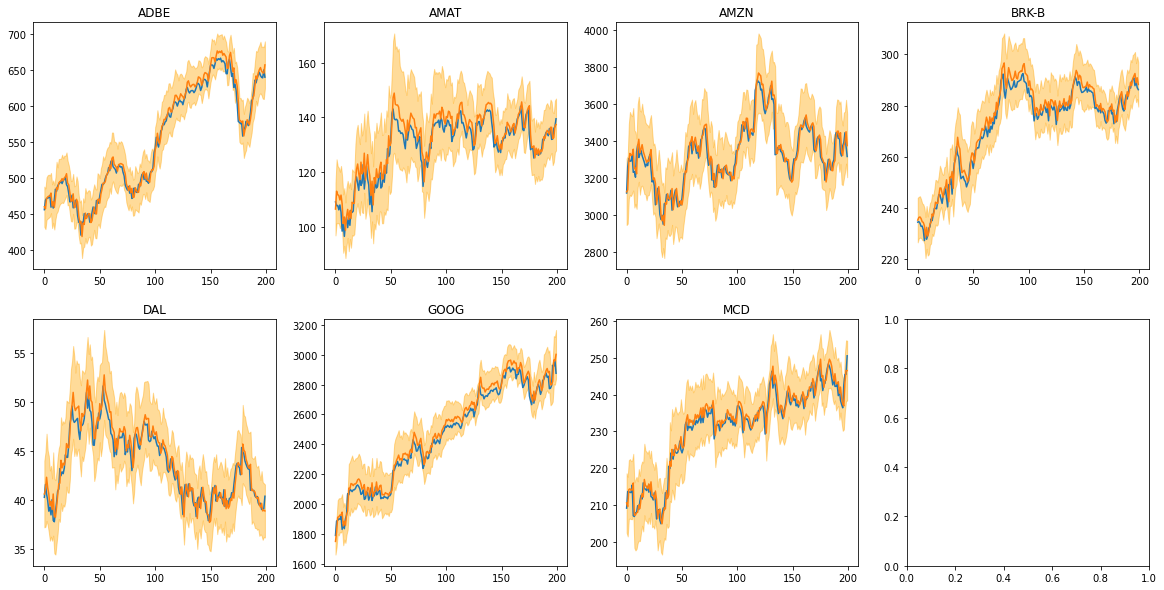

In [18]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    # ax[i].plot(torch.arange(-lookahead, -lookahead+num_obs+22), observations[i])
    ax[i].plot(observations[i, :-20])
    ax[i].plot(exp_means[i])
    ax[i].fill_between(
        torch.arange(num_obs), 
        (exp_means - 2 * exp_stds)[i],
        (exp_means + 2 * exp_stds)[i],
        alpha = 0.4, 
        color = "orange"
    )
    ax[i].set_title(tckrs[i])

In [19]:
returns_for_cov = (observations[..., lookahead:] - observations[..., :-lookahead]) \
    / observations[..., :-lookahead]

In [20]:
returns_for_cov.shape

torch.Size([7, 215])

In [21]:
lookahead_price = tenday_lookahead.exp()

In [22]:
lookahead_price.shape

torch.Size([7, 1000, 200])

In [23]:
returns_from_preds = (lookahead_price[..., lookahead:] - lookahead_price[..., :-lookahead]) \
    / lookahead_price[..., :-lookahead]

In [24]:
lookahead_price[..., lookahead:].shape

torch.Size([7, 1000, 195])

In [25]:
returns_from_obs = (lookahead_price[..., lookahead:] - observations[..., :-(lookahead+20)].unsqueeze(-2)) \
    / observations[..., :-(lookahead+20)].unsqueeze(-2)

In [26]:
returns_from_preds.shape

torch.Size([7, 1000, 195])

Text(0.5, 0.98, 'Predicted vs Actual Returns')

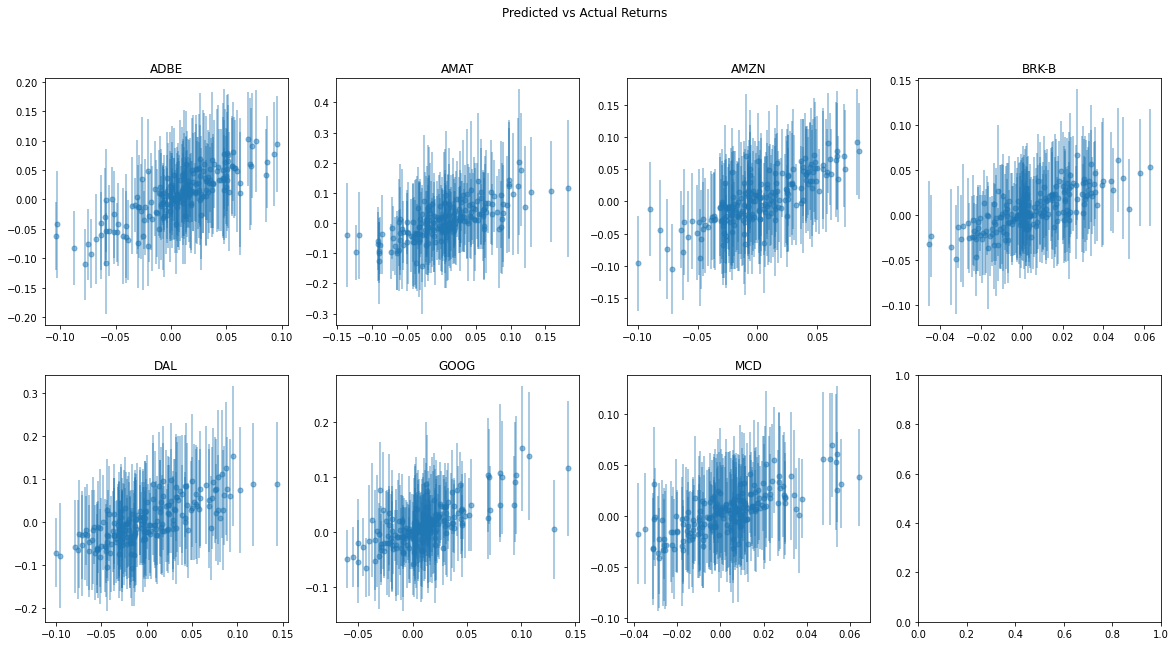

In [27]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    # ax[i].plot(torch.arange(-lookahead, -lookahead+num_obs+22), observations[i])
    ax[i].errorbar(returns_for_cov[i, :-20], returns_from_preds[i].mean(0), 
                   yerr=returns_from_preds[i].std(0) * 2., ls = "none",
                  marker = ".", markersize = 10, alpha = 0.5)
    ax[i].set_title(tckrs[i])
fig.suptitle("Predicted vs Actual Returns")

Text(0.5, 0.98, 'Observed vs Actual Returns')

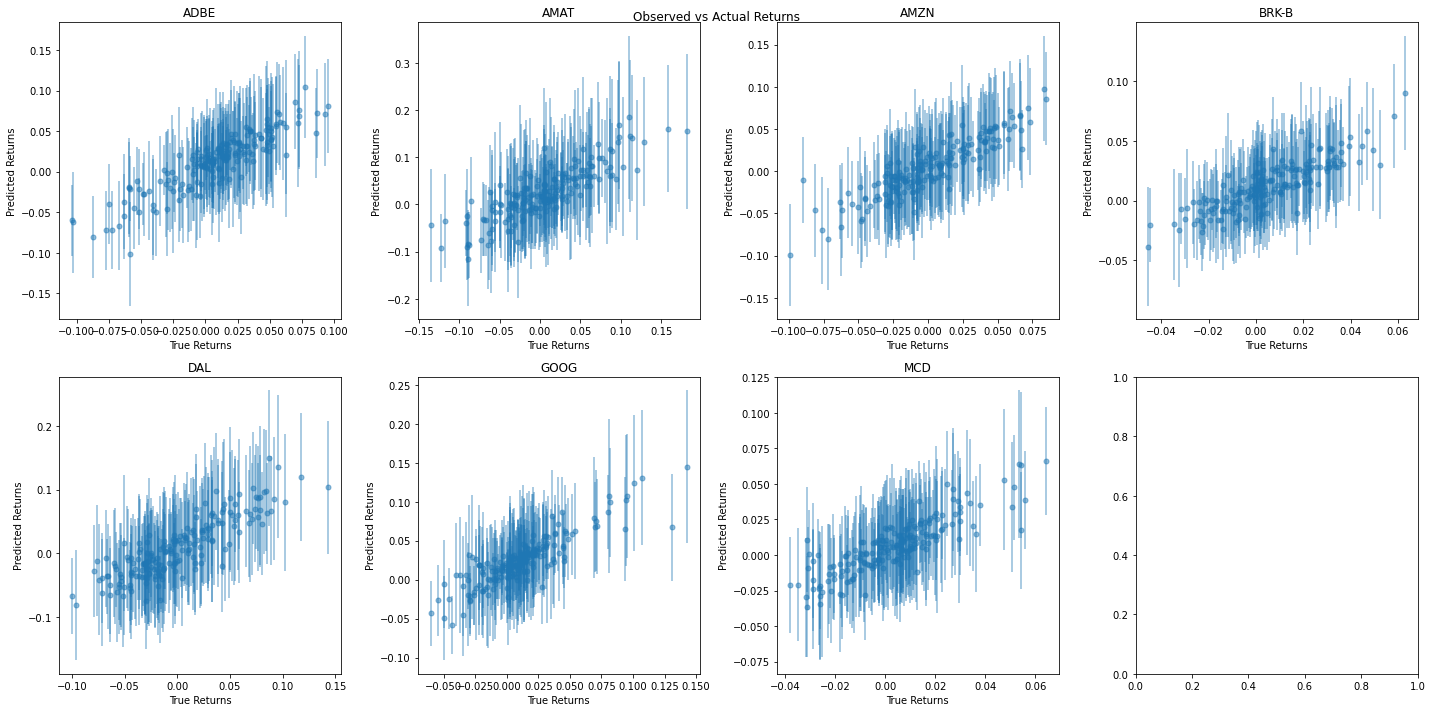

In [28]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    # ax[i].plot(torch.arange(-lookahead, -lookahead+num_obs+22), observations[i])
    ax[i].errorbar(returns_for_cov[i, :-20], returns_from_obs[i].mean(0), 
                   yerr=returns_from_obs[i].std(0) * 2., ls = "none",
                  marker = ".", markersize = 10, alpha = 0.5)
    ax[i].set_title(tckrs[i])
    ax[i].set_xlabel("True Returns")
    ax[i].set_ylabel("Predicted Returns")
plt.tight_layout()
fig.suptitle("Observed vs Actual Returns")

In [29]:
excess_returns = returns_from_obs - lookahead / 252 * 0.03

In [30]:
mean_excess_returns = excess_returns.mean(1)

In [31]:
cov_excess_returns = torch.stack([torch.cov(excess_returns[..., i]) for i in range(excess_returns.shape[-1])])

In [32]:
torch.cov(returns_for_cov[..., :20])

tensor([[ 1.4393e-03,  7.5224e-04,  6.1993e-04,  3.8623e-04,  2.3600e-04,
          1.7695e-03,  5.6368e-04],
        [ 7.5224e-04,  4.7996e-03, -1.6206e-04,  1.1875e-03,  2.2134e-03,
          8.4592e-04,  8.2810e-04],
        [ 6.1993e-04, -1.6206e-04,  6.7813e-04, -8.9523e-06, -2.9482e-04,
          9.0139e-04,  1.9338e-04],
        [ 3.8623e-04,  1.1875e-03, -8.9523e-06,  4.3055e-04,  9.3305e-04,
          6.3739e-04,  3.2608e-04],
        [ 2.3600e-04,  2.2134e-03, -2.9482e-04,  9.3305e-04,  3.1586e-03,
          1.1416e-03,  6.4746e-04],
        [ 1.7695e-03,  8.4592e-04,  9.0139e-04,  6.3739e-04,  1.1416e-03,
          3.0113e-03,  8.2891e-04],
        [ 5.6368e-04,  8.2810e-04,  1.9338e-04,  3.2608e-04,  6.4746e-04,
          8.2891e-04,  4.7063e-04]], dtype=torch.float64)

In [33]:
opt_excess_returns = returns_for_cov - lookahead / 252 * 0.03
cov_opt_excess_returns = torch.stack(
    [torch.cov(opt_excess_returns[..., :i]) for i in range(opt_excess_returns.shape[-1])]
)

/tmp/ipykernel_21305/1267487358.py:3: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/Correlation.cpp:99.)
  [torch.cov(opt_excess_returns[..., :i]) for i in range(opt_excess_returns.shape[-1])]


In [34]:
cov_opt_excess_returns[0:2] = cov_opt_excess_returns[2]

In [134]:
def compute_strategy(excess_returns, cov_est=None, normalize = False):
    if cov_est is None:
        batched_covs = torch.stack([torch.cov(excess_returns[..., i]) for i in range(excess_returns.shape[-1])])
    else:
        batched_covs = cov_est
    # expected_returns = excess_returns.mean(1)
    
    weights = torch.solve(excess_returns.t().unsqueeze(-1), batched_covs)[0]
    norm_constant = excess_returns.t().unsqueeze(-2).matmul(weights).sum(-1)
    res = weights.squeeze(-1) / norm_constant
    if normalize:
        res = res / res.abs().sum(1,keepdim=True)
    return res
    

In [135]:
weights = compute_strategy(mean_excess_returns, cov_opt_excess_returns[:-20], normalize=True) / (252 / 5)

In [136]:
opt_weights = compute_strategy(opt_excess_returns, cov_opt_excess_returns, normalize=True) / (252 / 5)

In [137]:
compute_pct_returns = lambda w: ((w * returns_for_cov[..., :-20]).sum(0)+1).cumprod(0)

In [139]:
opt_weights.shape

torch.Size([215, 7])

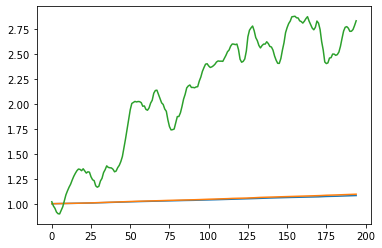

In [141]:
plt.plot(compute_pct_returns(weights.t()))
plt.plot(compute_pct_returns(opt_weights[:-20].t()))
plt.plot(compute_pct_returns(torch.ones_like(weights.t())/7))